In [62]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from pathlib import Path
import os
from MitoCode_Functions import GetData
from MitoCode_Functions import findLength, findLength2, findAvgWidth, findNumberofNodes, findVolume2, findDistofNodes, findPixelIntensity
# imports   

In [63]:
class node: 
    def __init__(self, dat, pointer, dist, conn): 
        self.start = dat 
        self.next = pointer
        self.dist = dist
        self.conn = conn
# class for a node

In [64]:
# creating 3d plot using matplotlib 
# in python
  
# for creating a responsive plot
%matplotlib widget
  
# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
  

def plotMitoWithNode2(PreOrPost, down = 0, up = 100, highlighted = 1): # takes in a pre or post image
    x = []
    y = []
    z = []

    x1 = []
    y1 = []
    z1 = []

    nX = []
    nY = []
    nZ = []


    nX1 = []
    nY1 = []
    nZ1 = []

    nodeDf = PreOrPost.loc[PreOrPost.nodeState == True]

    # fig = plt.figure(figsize=(4,4))
    # ax = fig.add_subplot(111, projection='3d')
    fig = plt.figure()
    ax = Axes3D(fig)
  

    for k in range(down, up):
        a = PreOrPost.loc[PreOrPost["cc"] == k]
       
        if k == highlighted: 
            x1.append(a["x"].values)
            y1.append(a["y"].values)
            z1.append(a["z"].values)

            na = nodeDf.loc[nodeDf["cc"] == k]
            nX1.append(na["x"].values)
            nY1.append(na["y"].values)
            nZ1.append(na["z"].values)


        else: 
            x.append(a["x"].values)
            y.append(a["y"].values)
            z.append(a["z"].values)

            na = nodeDf.loc[nodeDf["cc"] == k]
            nX.append(na["x"].values)
            nY.append(na["y"].values)
            nZ.append(na["z"].values)

    for i in range(len(x)): 

            ax.scatter(x[i], y[i] ,z[i], marker=".", color = "blue" )
            # ax.scatter(nX[i], nY[i], nZ[i], color = 'red')
    
    for i in range(len(x1)):
            ax.scatter(x1[i], y1[i] ,z1[i], marker=".", color = "green" )
            # ax.scatter(nX1[i], nY1[i], nZ1[i], color = 'orange')
    return 1

In [65]:
# # getting the files 
# # /home.
# direct3 = "/home/biratal/Desktop/Biolab/51/Pre/tif3" # enter the directory of where the mitograph-generated files are

direct3 = "/home/biratal/Desktop/Biolab/51/Pre/tif3/" # enter the directory of where the mitograph-generated files are

nodeDist3, nodeLists3, skelePos3, compList3 = GetData(direct3)

direct2 = "/home/biratal/Desktop/Biolab/51/Post/tif3/"
nodeDist2, nodeLists2, skelePos2, compList2 = GetData(direct2)


In [66]:
def getVolumeAndGroup(nodeTree, compList): # adds volume and group 
    nodeTree["Volume"] = None
    nodeTree["Group"] = None
    ntv = nodeTree.values
    clv = compList.values
    for i in ntv: 
        for j in clv:
            if i[0] == j[0] or i[1] == j[0]: 
                i[3] = j[2]
                i[4] = j[1]
    nodeTree = pd.DataFrame(ntv, columns=["X", "Y", "dist", "Volume", "Group"])
    return nodeTree
# function to clean the nodeDist, as it is has different columns
def cleanNodeDist(nodeDist, compList):  
    a = nodeDist[nodeDist.columns[0]]
    lis = np.array(list(a.items()), dtype = object)
    A = []

    for i in lis: 
        A.append([i[0], i[1]])
    nlis = np.array(lis, dtype = object)
    X = []
    Y = []
    dist = []

    for i in range(len(nlis)): 
        x, y = nlis[i][0]
        X.append(x)
        Y.append(y)
        dist.append(nlis[i][1])

    X = np.array(X)
    Y = np.array(Y)
    dist = np.array(dist)
    nTree = pd.DataFrame({"X": X, "Y":Y, "dist":dist})
    return getVolumeAndGroup(nTree, compList)
# cleaning data for node coordinates
def cleanCoordinate(nodeLists):
    A = []
    for i in nodeLists.columns: 
        A.append(float(i))
    Blist = []
    Blist.append(A)
    # 
    for i in nodeLists.values: 
        Blist.append(list(i))
    return pd.DataFrame(np.array(Blist), columns= ["x", "y", "z"])
# adding nodes
def addNodes(skelePos, nodeCoordinates):
    roundSkele = skelePos.round(4)
    a = nodeCoordinates[['x', 'y', 'z']].values.tolist()
    b = roundSkele[['x', 'y', 'z']].values.tolist()

    roundSkele["nodeState"] = False
    roundSkele["node"] = None
    notFoundList = [] # list for coordinates that weren't found because of rounding

    for i in range(len(b)): 
        for j in range(len(a)): 
            if b[i] == a[j]: 
                roundSkele.at[i, "nodeState"] = True
                roundSkele.at[i, "node"] = j    
    return roundSkele
# get the group given the node
def getCCfromNode(compList3, node): 
    a = compList3.loc[compList3.Node == node]
    return a.Belonging_CC.values[0]
# get the node given the group
def getNodefromCC(compList3, cc): 
    a = compList3.loc[compList3.Belonging_CC == cc]
    return a.Node.values
# Find the groups 
def FindGroup(df, compList): 
    if len(df.node.values) >1:
        liz = list(filter(None, df.node.values))
        if len(liz) >= 1:
            Node = liz[0]
            n = list(compList.values[:, 0])
            cc = compList.values[:, 1]
            return cc[n.index(Node)]
        else: 
            return -1
# generate the dataframe with
def genBigDf(skelePos, compList, nodeLists):
    nodeCoordinates = cleanCoordinate(nodeLists)
    roundSkele = addNodes(skelePos, nodeCoordinates)
    maxline_id = max(roundSkele.line_id.values)

    roundSkele["cc"] = None
    test = []

    for i in range(maxline_id + 1):
        df = roundSkele.loc[roundSkele.line_id == i]
        test.append(df)

    for i in range(len(test)): 
        test[i].cc = FindGroup(test[i], compList)

    return pd.concat(test)
# find the distance between nodes 
def lengthList(bigDf1, temp): # produces a list with the longest (in length) to shortest (in length)
        maxcc = bigDf1.cc.max()
        Ls = []
        for k in range(int(maxcc)):
            test = bigDf1.loc[bigDf1.cc == k]
            linids = []
            lens = []
            endparts = []

            for i in set(test.line_id): 
                secTest = test.loc[test.line_id == i]
                b = secTest.loc[secTest.nodeState == True]
                if len(b) < 2: 
                    endparts.append(secTest)
                else: 
                    linids.append(b)
                
            for i in linids: 
                nodesInid = i.node.values
                lens.append(findDistofNodes(nodesInid[0], nodesInid[1], temp))

            for j in endparts: 
                lens.append(findLength2(j))
            
            Ls.append(np.sum(lens))

            # Ls.append([np.sum(lens), int(k)])
        # sorted_ls = sorted(Ls, key=lambda x: x[0], reverse=True)
        return Ls

def findBranching(df):
    return len(set(df.line_id.values))

def getLineIdFromCC(df, c): 
    a = df.loc[df.cc == c]
    return set(a.line_id.values)
    
def findCCfromLineId(df, linid):
    a = df.loc[df.line_id == linid]
    return a.cc.values[0] 

# getting it for the entire thing

def getFinalDat_entire(bigDf, temp): 
    maxcc = max(bigDf.cc)
    dat = []
    datfunc = []
    for i in range(int(maxcc + 1)):
        d = bigDf[bigDf.cc == i]
        dat.append([i, findLength(d, temp), findVolume2(d), findBranching(d), findNumberofNodes(d), findPixelIntensity(d)])
        # datfunc.append([findPixelIntensity(d)])
    sorted_ls = sorted(dat, key=lambda x: x[2], reverse=True)
    return pd.DataFrame(dat, columns=['cc', 'Length', 'Volume', 'Number of Branches', 'Number of Nodes', 'pixint'])

def getFinalDat_element(bigDf, temp): 
    maxcc = max(bigDf.line_id)
    dat = []
    datfunc = []
    for i in range(int(maxcc + 1)):
        d = bigDf[bigDf.line_id == i]
        dat.append([i, findLength(d, temp), findVolume2(d), findAvgWidth(d), findCCfromLineId(d, i), findPixelIntensity(d)])
        # datfunc.append([findPixelIntensity(d)])
    sorted_ls = sorted(dat, key=lambda x: x[2], reverse=True)
    return pd.DataFrame(dat, columns=['lineid', 'Length', 'Volume', 'Width', 'cc', 'pixint'])

def getPixelFromGeometrical(x_geometric, y_geometric, z_geometric): 
    pixel_size_x = 0.104
    pixel_size_y = 0.104
    pixel_size_z = 0.5

    x_pixel = int((x_geometric - 0) / pixel_size_x)
    y_pixel = int((y_geometric - 0) / pixel_size_y)
    z_pixel = int((z_geometric - 0) / pixel_size_z)
    return x_pixel, y_pixel, z_pixel

def getPixelIntensityFromPixel(arr, x, y, z):     
    return arr[z][x, y]
    
def addFunctional(df, image, image2):
    for i in range(len(df)): 
        x1, y2, z3 = df.loc[i, ['x', 'y', 'z']].values
        x, y, z = getPixelFromGeometrical(x1, y2, z3)
        
        a = getPixelIntensityFromPixel(image, y, x, z)
        b = getPixelIntensityFromPixel(image2, y, x, z)

        df.loc[i, 'pixint1'] = getPixelIntensityFromPixel(image, y, x, z)
        df.loc[i, 'pixint2'] = getPixelIntensityFromPixel(image2, y, x, z)
           
        if a and b != 0: 
            df.loc[i, 'pix_ratio'] = np.round(a/b, 3)
        else: 
            df.loc[i, 'pix_ratio'] = None 
            
        df.loc[i, 'pposx'] = x
        df.loc[i, 'pposy'] = y
        df.loc[i, 'pposz'] = z
 
    return df


In [67]:
import imageio
imagepre1 = imageio.volread("/home/biratal/Desktop/Biolab/51/Pre/tif1/C1-ANTPRE051.tif")
imagepre2 = imageio.volread("/home/biratal/Desktop/Biolab/51/Pre/tif2/C2-ANTPRE051.tif")

imagepost1 = imageio.volread("/home/biratal/Desktop/Biolab/51/Post/tif1/C1-ANTPOST051.tif")
imagepost2 = imageio.volread("/home/biratal/Desktop/Biolab/51/Post/tif2/C2-ANTPOST051.tif")

bigDf1 = genBigDf(skelePos3, compList3, nodeLists3)
# temp = cleanNodeDist(nodeDist3, compList3)
bigDf2 = genBigDf(skelePos2, compList2, nodeLists2)
# temp2 = cleanNodeDist(nodeDist2, compList2)

/tmp/ipykernel_43338/42215545.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i].cc = FindGroup(test[i], compList)
/tmp/ipykernel_43338/42215545.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i].cc = FindGroup(test[i], compList)


In [68]:
bigDf1 = addFunctional(bigDf1, imagepre1, imagepre2)
bigDf2 = addFunctional(bigDf2, imagepost1, imagepost2)

In [25]:
# # calculating the length
# bigDf1 = genBigDf(skelePos3, compList3, nodeLists3)
# temp = cleanNodeDist(nodeDist3, compList3)
# roundSkele = addNodes(skelePos3, cleanCoordinate(nodeLists3))
# a = lengthList(bigDf1, temp)

In [69]:
# bigDf1 = genBigDf(skelePos3, compList3, nodeLists3)
temp = cleanNodeDist(nodeDist3, compList3)

# bigDf2 = genBigDf(skelePos2, compList2, nodeLists2)
temp2 = cleanNodeDist(nodeDist2, compList2)

# import imageio
# imagepre1 = imageio.volread("/home/biratal/Desktop/Biolab/51/Pre/tif1/C1-ANTPRE051.tif")
# imagepre2 = imageio.volread("/home/biratal/Desktop/Biolab/51/Pre/tif2/C2-ANTPRE051.tif")

# imagepost1 = imageio.volread("/home/biratal/Desktop/Biolab/51/Post/tif1/C1-ANTPOST051.tif")
# imagepost2 = imageio.volread("/home/biratal/Desktop/Biolab/51/Post/tif2/C2-ANTPOST051.tif")



In [70]:

preElement = getFinalDat_element(bigDf1, temp)
preEntire = getFinalDat_entire(bigDf1, temp)

postElement = getFinalDat_element(bigDf2, temp2)
postEntire = getFinalDat_entire(bigDf2, temp2)

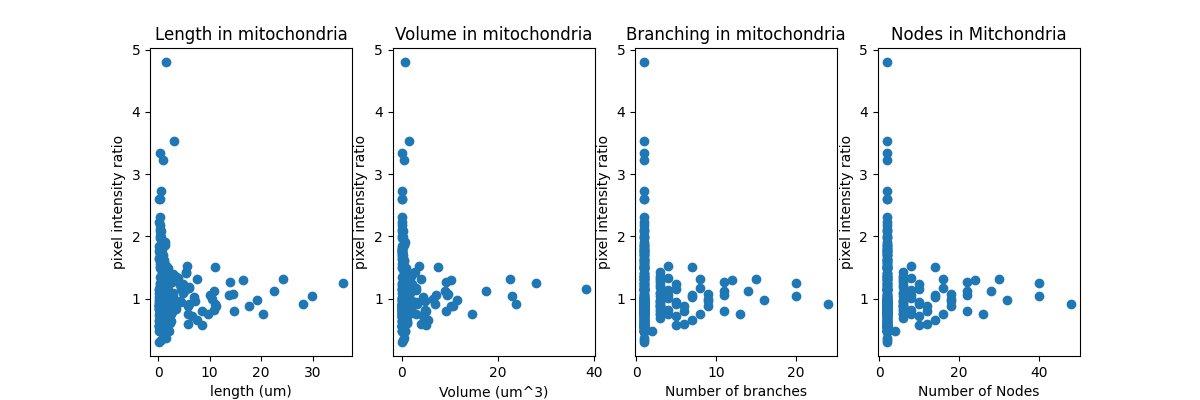

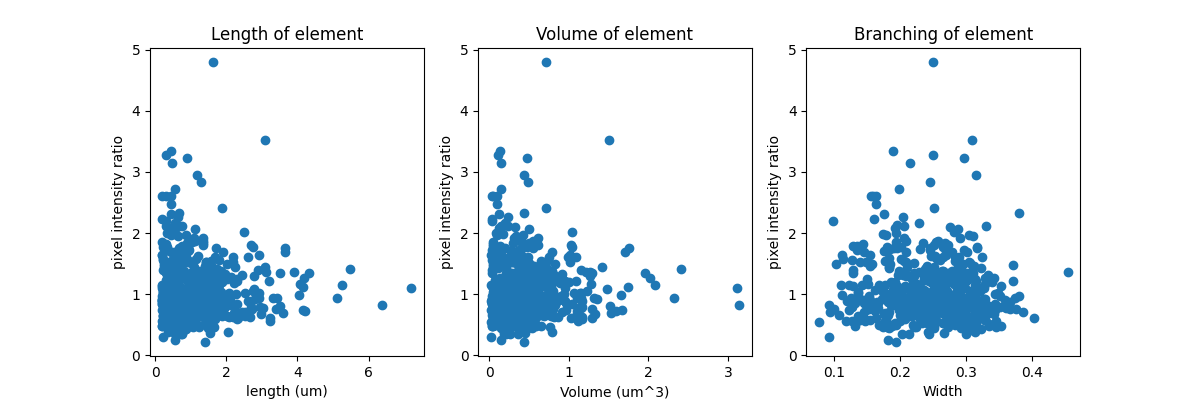

In [72]:
# plt.scatter(dat[:, 1], datfunc)
# plt.xlabel("length (um)")
# plt.ylabel("pixel_intensity_ratio")
# plt.xlim(0, 200)

def plotGraphsEntire(df, title = "Per Mitochondria: "):
    dat = df.values
    datfunc = df['pixint'].values
    fig, ax = plt.subplots(1,4, figsize=(12,4))
    plt.suptitle(title)
    # plot each image on its own axis
    ax[0].scatter(dat[:, 1], datfunc, cmap='gray')
    ax[0].set_xlabel("length (um)")
    ax[0].set_ylabel("pixel intensity ratio")
    ax[0].set_title("Length in mitochondria")


    ax[1].scatter(dat[:, 2], datfunc, cmap='gray')
    ax[1].set_xlabel("Volume (um^3)")
    ax[1].set_ylabel("pixel intensity ratio")
    ax[1].set_title("Volume in mitochondria")


    ax[2].scatter(dat[:, 3], datfunc, cmap='gray')
    ax[2].set_xlabel("Number of branches")
    ax[2].set_ylabel("pixel intensity ratio")
    ax[2].set_title("Branching in mitochondria")


    ax[3].scatter(dat[:, 4], datfunc)
    ax[3].set_xlabel("Number of Nodes")
    ax[3].set_ylabel("pixel intensity ratio")
    ax[3].set_title("Nodes in Mitchondria")


    # ax[0].set_xlim(0, 50)
    # ax[1].set_xlim(0, 50)
    # ax[2].set_xlim()
    # ax[3].set_xlim(0, 100)


    # # turn off axis labels
    # ax[0].axis('off')
    # ax[1].axis('off')
    # ax[2].axis('off')

    plt.show()

def plotGraphsElement(df, title = "Per connected element"):
    dat = df.values
    datfunc = df['pixint'].values
    fig, ax = plt.subplots(1,3, figsize=(12,4))
    plt.suptitle(title)
    # plot each image on its own axis
    ax[0].scatter(dat[:, 1], datfunc, cmap='gray')
    ax[0].set_xlabel("length (um)")
    ax[0].set_ylabel("pixel intensity ratio")
    ax[0].set_title("Length of element")


    ax[1].scatter(dat[:, 2], datfunc, cmap='gray')
    ax[1].set_xlabel("Volume (um^3)")
    ax[1].set_ylabel("pixel intensity ratio")
    ax[1].set_title("Volume of element")


    ax[2].scatter(dat[:, 3], datfunc, cmap='gray')
    ax[2].set_xlabel("Width")
    ax[2].set_ylabel("pixel intensity ratio")
    ax[2].set_title("Branching of element")


    # ax[0].set_xlim(0, 50)
    # ax[1].set_xlim(0, 50)
    # ax[2].set_xlim()
    # ax[3].set_xlim(0, 100)


    # # turn off axis labels
    # ax[0].axis('off')
    # ax[1].axis('off')
    # ax[2].axis('off')

    plt.show()

# plotGraphs(dat1, datfunc1, "Pre" )
plotGraphsEntire(preEntire, "")
plotGraphsElement(preElement, "")


/tmp/ipykernel_43338/3144291716.py:35: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


1

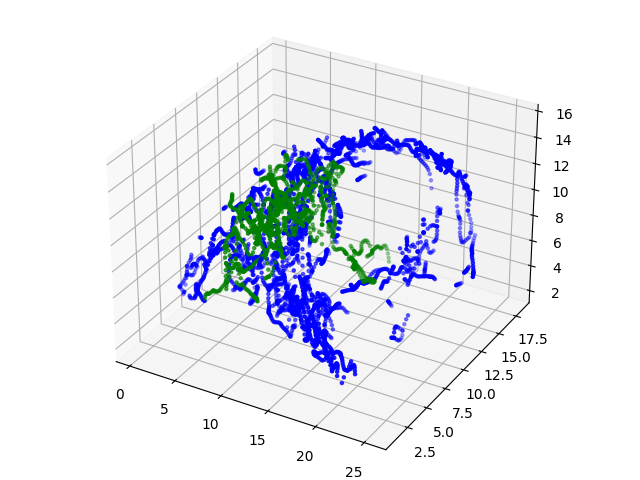

In [77]:
plotMitoWithNode2(bigDf2, highlighted = 35)

In [ ]:
bigDf1.loc[bigDf1.cc == 1]["node"].values

array([34, None, None, None, None, None, None, None, None, None, None, 22,
       21, None, 22, 22, None, None, None, None, None, None, 21, 21, None,
       None, None, None, 20], dtype=object)

In [ ]:
nodeDist1

693
692 689  1.32115
691 690  0.20800
689 619  1.70994
    684  0.72796
688 538  4.00184
...          ...
89  88   1.07667
68  49   1.97291
39  10   1.62224
35  23   2.77027
51  14   4.01601

[594 rows x 1 columns]

In [ ]:
# find the closest coordinate 
min  = np.inf
pos = 0
foundCor = 0 
for i in notFoundList: 
    for j in b: 
        pos += 1
        g = Dist(a[i], j)
        if g < min: 
            foundCor = j
            min = g
roundSkele.loc[roundSkele.x == 0.624]

NameError: name 'notFoundList' is not defined

In [ ]:
roundSke

,line_id,point_id,x,y,z,width_(um),pixel_intensity
0,0,0,0.31200,7.38400,2.00000,0.08327,110.00000
1,0,1,0.38573,7.28000,2.31481,0.25726,93.66667
2,0,2,0.41214,7.17600,2.59259,0.23886,200.00000
3,0,3,0.41986,7.07200,2.79630,0.36456,136.00000
4,0,4,0.44647,6.96800,2.92593,0.32325,172.83333
...,...,...,...,...,...,...,...
4248,593,23,20.05687,15.06852,13.88889,0.31234,136.50000
4249,593,24,19.98973,14.95041,13.99074,0.15017,139.83333
4250,593,25,19.87507,14.86073,14.12963,0.22289,116.00000
4251,593,26,19.76183,14.76617,14.30556,0.27734,136.00000


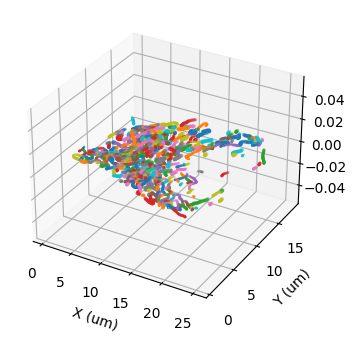

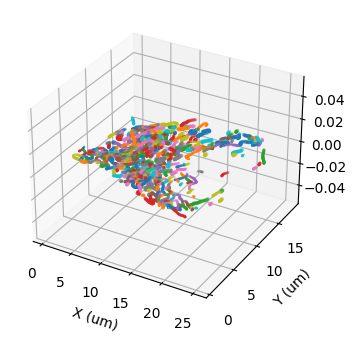

In [ ]:
plotMito(skelePos1)

In [ ]:
def plotMito(PreOrPost, j = -1): # takes in a pre or post image
    x = []
    y = []
    z = []
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111, projection='3d')
    if j != -1: 
        a = PreOrPost.loc[PreOrPost["line_id"] == j]
        x.append(a["x"].values)
        y.append(a["y"].values)
        z.append(a["z"].values)
    else:
        for k in range(PreOrPost["line_id"].max()):
        # for k in range(100):
            a = PreOrPost.loc[PreOrPost["line_id"] == k]
            x.append(a["x"].values)
            y.append(a["y"].values)
            z.append(a["z"].values)
    for i in range(len(x)): 
        plt.scatter(x[i], y[i] ,z[i], marker="." )
    plt.xlabel("X (um)")
    plt.ylabel("Y (um)")

    return fig

In [ ]:
def plotMitoWithNode(PreOrPost, nodeDf, down = 0, up = 100): # takes in a pre or post image
    x = []
    y = []
    z = []

    nX = []
    nY = []
    nZ = []

    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111, projection='3d')

    for k in range(down, up):
        a = PreOrPost.loc[PreOrPost["line_id"] == k]
       
        x.append(a["x"].values)
        y.append(a["y"].values)
        z.append(a["z"].values)

        na = nodeDf.loc[nodeDf["line_id"] == k]
        nX.append(na["x"].values)
        nY.append(na["y"].values)
        nZ.append(na["z"].values)

    for i in range(len(x)): 
        plt.scatter(x[i], y[i] ,z[i], marker=".", color = "blue" )
        plt.scatter(nX[i], nY[i], nZ[i], color = 'red')
    plt.xlabel("X (um)")
    plt.ylabel("Y (um)")
    return 1

NameError: name 'nodeCoordinates' is not defined

In [ ]:
# creating 3d plot using matplotlib 
# in python
  
# for creating a responsive plot
%matplotlib widget
  
# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
  

def plotMitoWithNode2(PreOrPost, down = 0, up = 100, highlighted = 1): # takes in a pre or post image
    x = []
    y = []
    z = []

    x1 = []
    y1 = []
    z1 = []

    nX = []
    nY = []
    nZ = []


    nX1 = []
    nY1 = []
    nZ1 = []

    nodeDf = PreOrPost.loc[PreOrPost.nodeState == True]

    # fig = plt.figure(figsize=(4,4))
    # ax = fig.add_subplot(111, projection='3d')
    fig = plt.figure()
    ax = Axes3D(fig)
  

    for k in range(down, up):
        a = PreOrPost.loc[PreOrPost["cc"] == k]
       
        if k == highlighted: 
            x1.append(a["x"].values)
            y1.append(a["y"].values)
            z1.append(a["z"].values)

            na = nodeDf.loc[nodeDf["cc"] == k]
            nX1.append(na["x"].values)
            nY1.append(na["y"].values)
            nZ1.append(na["z"].values)


        else: 
            x.append(a["x"].values)
            y.append(a["y"].values)
            z.append(a["z"].values)

            na = nodeDf.loc[nodeDf["cc"] == k]
            nX.append(na["x"].values)
            nY.append(na["y"].values)
            nZ.append(na["z"].values)

    for i in range(len(x)): 

            ax.scatter(x[i], y[i] ,z[i], marker=".", color = "blue" )
            # ax.scatter(nX[i], nY[i], nZ[i], color = 'red')
    
    for i in range(len(x1)):
            ax.scatter(x1[i], y1[i] ,z1[i], marker=".", color = "green" )
            # ax.scatter(nX1[i], nY1[i], nZ1[i], color = 'orange')
    return 1

In [ ]:
bigDf1

,line_id,point_id,x,y,z,width_(um),pixel_intensity,nodeState,node,cc
0,0,0,0.3120,7.3840,2.0000,0.0833,110.0000,True,692,100.0
1,0,1,0.3857,7.2800,2.3148,0.2573,93.6667,False,None,100.0
2,0,2,0.4121,7.1760,2.5926,0.2389,200.0000,False,None,100.0
3,0,3,0.4199,7.0720,2.7963,0.3646,136.0000,False,None,100.0
4,0,4,0.4465,6.9680,2.9259,0.3232,172.8333,False,None,100.0
...,...,...,...,...,...,...,...,...,...,...
4248,593,23,20.0569,15.0685,13.8889,0.3123,136.5000,False,None,15.0
4249,593,24,19.9897,14.9504,13.9907,0.1502,139.8333,False,None,15.0
4250,593,25,19.8751,14.8607,14.1296,0.2229,116.0000,False,None,15.0
4251,593,26,19.7618,14.7662,14.3056,0.2773,136.0000,False,None,15.0


/tmp/ipykernel_3964/892837584.py:35: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


1

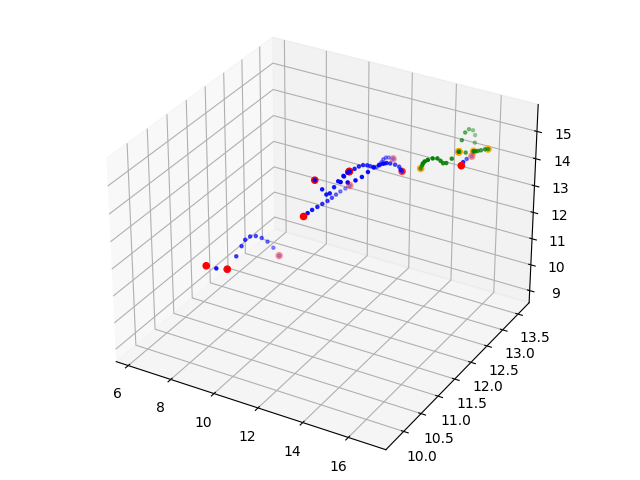

In [ ]:
plotMitoWithNode2(bigDf1, 0, 5, 1)

In [ ]:
datDf1

NameError: name 'datDf1' is not defined

In [ ]:
bigDf2

,line_id,point_id,x,y,z,width_(um),pixel_intensity,nodeState,node,cc
0,0,0,2.7040,16.0160,1.5000,0.1480,69.5000,True,798,150.0
1,0,1,2.7341,15.9120,1.7407,0.2161,77.8333,False,None,150.0
2,0,2,2.8080,15.8080,2.0000,0.1384,84.1667,True,796,150.0
3,1,0,0.3120,7.4880,2.0000,0.0559,79.3333,True,797,12.0
4,1,1,0.3857,7.3840,2.2407,0.4618,63.5000,False,None,12.0
...,...,...,...,...,...,...,...,...,...,...
5008,739,2,14.9751,12.8195,14.3796,0.3915,162.0000,False,None,1.0
5009,739,3,14.8829,12.7585,14.4259,0.3230,174.3333,False,None,1.0
5010,739,4,14.7895,12.6880,14.4352,0.2670,183.1667,False,None,1.0
5011,739,5,14.6449,12.6731,14.4537,0.3947,204.0000,False,None,1.0


In [ ]:
dt =[]
for i in range(70): 
    a = skelePos.loc[skelePos["line_id"] == i]
    width = skelePos.loc[skelePos["line_id"] == i].mean()["width_(um)"]
    pixelIntensity = skelePos.loc[skelePos["line_id"] == i].mean()["pixel_intensity"]
    a["avgwidth"] = [width] * len(a)
    a["avgpixelIntensity"] = [pixelIntensity] * len(a)

    dt.append(a)

/tmp/ipykernel_13939/3586055512.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a["avgwidth"] = [width] * len(a)
/tmp/ipykernel_13939/3586055512.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a["avgpixelIntensity"] = [pixelIntensity] * len(a)
/tmp/ipykernel_13939/3586055512.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [ ]:
indexList = []
for i in range(len(nodeCoordinates)): 
    indexList.append(i)
    
nodeCoordinates["node"] = indexList 
# nodeCoordinates # contains node positions and node name

In [ ]:
w = []
pi = []
for i in dt: 
    w.append(i["avgwidth"].values[0])
    pi.append(i["avgpixelIntensity"].values[0])


Text(0, 0.5, 'functional, pixel intensity')

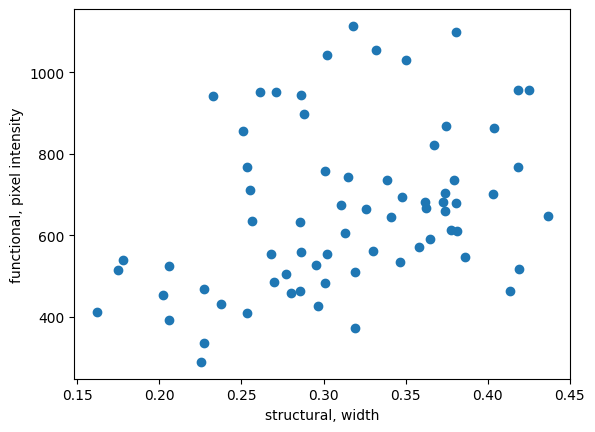

In [ ]:
plt.scatter(w, pi)
plt.xlabel("structural, width")
plt.ylabel("functional, pixel intensity")

In [ ]:
# # recursive function to get the different branches, get it manually 
# # doesn't work for larger ones 

# mnemonicList = []

# def getPath(conList, nodeOne, print = True): # list of connections, start node
#     if print == True: 
#         if nodeOne.next == -1:
#             return conList.append(nodeOne.start)
#         for i in nodeOne.conn: 
#             conList.append(i.start)
#             (getPath(conList, i))
#         return conList
#     else: 
#         if nodeOne.next == -1:
#             return conList.append(nodeOne)
#         for i in nodeOne.conn: 
#             conList.append(i)
#             (getPath(conList, i, False))
#         return conList

# def printPath(a): 
#     i = 0 
#     while i < len(a) - 1:
#         if a[i + 1] != a[i]: 
#             print(a[i], end = "-> ")
#             i += 1
#         else: 
#             print(a[i])
#             i += 2
#             print("  \t", end = "")
            
# k = -2
# a = getPath([nodeList[k].start], nodeList[k], print = True)
# b = getPath([nodeList[k]], nodeList[k], print = False)
# def getBranchdf (a):
#     dfList = []
#     pointList = []
#     for i in a: 
#         if i not in pointList: 
#             pointList.append(i)
#             try: 
#                 dfList.append(nodeTree.loc[nodeTree["X"] == i]) 
#             except: 
#                 IndexError
#     return pd.concat(dfList)
    
# def getGlobalDfList(originNodeList):
#     globalDfList = []
#     for k in range(len(originNodeList)): 
#         a = getBranchdf(getPath([originNodeList[k].start], originNodeList[k], print = True))
#         globalDfList.append(a)
#     return globalDfList

In [ ]:

# def createNodeList(nodeTree): # creates a list of nodes from a dataframe and returns it
#     arr = np.array(nodeTree.values)
#     startArr = arr[:, 0] # node 1
#     nextArr = arr[:, 1] # node 2 
#     distArr = arr[:, 2] # distance 

#     # nodes with connections
#     nodeList = []
#     for i in range(len(startArr)): 
#         nodeList.append(node(startArr[i], nextArr[i], distArr[i], []))

#     # nodes without connections

#     for i in nextArr: 
#         if i not in startArr: 
#             nodeList.append(node(i, -1, 0, []))

#     # if a mitochondria branches out from one point to several, we need a dummy node that points to it

#     bunchem = []
#     for i in startArr: # ones with many branches but nothing pointng to it
#         if np.count_nonzero(startArr == i) > 1: 
#             if i not in nextArr: 
#                 bunchem.append(i)

#     bunchem = list(set(bunchem))
#     all = np.append(nextArr, startArr)
#     count = max(all) + 1

#     for i in bunchem: 
#         nodeList.append(node(count, i, 0, [] ))
#         count += 1

#     return nodeList

# # find the start points of the mitochondria branching
# def getOrigins(nodeList): # returns originNodeList and a list with the origins in it
#     origins = []
#     startArr2 = []
#     nextArr2 = []

#     for i in nodeList: 
#         startArr2.append(i.start)
#         nextArr2.append(i.next) 

#     for i in startArr2: 
#         if i not in nextArr2: 
#             origins.append(i)

#     originNodeList = []

#     for i in origins: 
#         for j in nodeList: 
#             if j.start == i: 
#                 originNodeList.append(j)
    
#     return originNodeList, origins

# def getConnections(nodeList): 
#     for i in nodeList: 
#         tempList = []
#         for j in nodeList:
#             if i.next == j.start: 
#                 tempList.append(j)
#         i.conn = tempList
    
# nodeList = createNodeList(nodeTree)
# originNodeList, origins = getOrigins(nodeList)
# getConnections(nodeList)

In [ ]:
# def numOfNodes(df): 
#     return len(set(np.append(df["X"].values, df["Y"].values)))



# def getPost(skelePos, coordinates, node):
#     coors = coordinates[node]
#     a = coors[0]
#     b = coors[1]
#     c = coors[2]
#     first = skelePos.loc[skelePos["x"] == a]
#     if len(first) == 0: 
#             return print("didn't work")
#     if len(first) > 1: 
#         second = first.loc[first["y"] == b]
#         second.at[0, "node"] = node
#         if len(second) == 0: 
#             return print("didn't work")
#         if len(second) > 1: 
#             third = second.loc[second["z"] == c]
#             third.at[0, "node"] = node
#             if len(third) == 1: 
#                 if len(third) == 0: 
#                     return print("didn't work")
#                 return third
#         else: 
#             if len(second) == 1: 
#                 return second 
#     else: 
#         first.at[0, "node"] = node
#         gotIt = True
#         if len(first) == 1:
#             return first

# roundSkele = skelePos.round(4)
# df = []
# for i in range(114):
#     a = getPost(roundSkele, nodeCoordinates.values, i)
#     df.append(a)

